In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 13.5 MB/s eta 0:00:00


In [ ]:
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from jiwer import wer, cer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
import re

In [ ]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
# Check if GPU is available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


In [ ]:
# Create output directory
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = '/content/drive/MyDrive/output_lstm_char/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

Mounted at /content/drive


In [ ]:
# # Create output directory
# OUTPUT_DIR = './output_lstm_char/'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

In [ ]:
# Paths for saving/loading
DATASET_PATH = './exportStatements.xlsx'
VOCAB_PATH = os.path.join(OUTPUT_DIR, 'char_vocab.pkl')
PREPROCESSED_DATA_PATH = os.path.join(OUTPUT_DIR, 'preprocessed_data_char.pkl')
BEST_MODEL_PATH = os.path.join(OUTPUT_DIR, 'best_lstm_model_char.pt')
BEST_CER_MODEL_PATH = os.path.join(OUTPUT_DIR, 'best_lstm_model_cer.pt')
LOSS_PLOT_PATH = os.path.join(OUTPUT_DIR, 'lstm_loss_plot_char.png')
ER_PLOT_PATH = os.path.join(OUTPUT_DIR, 'er_plot.png')

In [ ]:
# Load the dataset
df = pd.read_excel(DATASET_PATH)

In [ ]:
# Check for missing values in 'inFormalForm' and 'FormalForm'
print("Missing values in 'inFormalForm':", df['inFormalForm'].isnull().sum())
print("Missing values in 'FormalForm':", df['FormalForm'].isnull().sum())

# Drop rows with missing values in 'inFormalForm' and 'FormalForm'
initial_length = len(df)
df = df.dropna(subset=['inFormalForm', 'FormalForm']).reset_index(drop=True)
final_length = len(df)

df['inFormalForm'] = df['inFormalForm'].astype(str)
df['FormalForm'] = df['FormalForm'].astype(str)

print(f"Dropped {initial_length - final_length} rows due to missing values.")

Missing values in 'inFormalForm': 0
Missing values in 'FormalForm': 1
Dropped 1 rows due to missing values.


In [ ]:
def clean_persian_text(text):
    # 1. Keep only Persian letters, English letters, digits, whitespace, ZWNJ
    text = re.sub(r"[^\u0600-\u06FFa-zA-Z0-9\u06F0-\u06F9\u0660-\u0669\u200c\s]", " ", text)
    # Remove leftover Persian punctuations explicitly (، ؛ ؟)
    text = re.sub(r"[،؛؟]", " ", text)
    # Remove Arabic diacritics (harakat)
    arabic_diacritics = r"[\u064B-\u065F\u0670\u06D6-\u06ED]"
    text = re.sub(arabic_diacritics, "", text)

    # 2. Normalize Persian/Arabic digits to Western digits
    persian_digits = "۰۱۲۳۴۵۶۷۸۹"
    arabic_digits = "٠١٢٣٤٥٦٧٨٩"
    for p, a, e in zip(persian_digits, arabic_digits, "0123456789"):
        text = text.replace(p, e).replace(a, e)

    # 3. Separate numbers stuck to Persian/English letters
    text = re.sub(r"(\d+)(?=[\u0600-\u06FFa-zA-Z])", r"\1 ", text)  # digit before letter
    text = re.sub(r"([\u0600-\u06FFa-zA-Z])(?=\d+)", r"\1 ", text)  # letter before digit

    # 4. Remove underscores
    text = re.sub(r"_+", "", text)

    # 5. Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [ ]:
df['inFormalForm'] = df['inFormalForm'].apply(clean_persian_text)
df['FormalForm'] = df['FormalForm'].apply(clean_persian_text)

In [ ]:
# Split data into training, validation, and test sets (80%, 10%, 10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

In [ ]:
# Build character vocabulary from training data
if not os.path.exists(VOCAB_PATH):
    print('Building character vocabulary...')
    all_text = ''.join(train_df['inFormalForm'].tolist() + train_df['FormalForm'].tolist())
    chars = sorted(list(set(all_text)))
    # Add special tokens
    special_tokens = ['<pad>', '<unk>', '<s>', '</s>']
    char2idx = {char: idx + len(special_tokens) for idx, char in enumerate(chars)}
    for idx, token in enumerate(special_tokens):
        char2idx[token] = idx
    idx2char = {idx: char for char, idx in char2idx.items()}
    # Save vocabulary
    with open(VOCAB_PATH, 'wb') as f:
        pickle.dump({'char2idx': char2idx, 'idx2char': idx2char}, f)
    print('Character vocabulary built and saved.')
else:
    print('Loading existing character vocabulary...')
    with open(VOCAB_PATH, 'rb') as f:
        vocab = pickle.load(f)
        char2idx = vocab['char2idx']
        idx2char = vocab['idx2char']

Loading existing character vocabulary...


In [ ]:
# Special token IDs
PAD_IDX = char2idx['<pad>']
UNK_IDX = char2idx['<unk>']
BOS_IDX = char2idx['<s>']
EOS_IDX = char2idx['</s>']

PAD_IDX, UNK_IDX, BOS_IDX, EOS_IDX

(0, 1, 2, 3)

In [ ]:
# Maximum sequence length (based on dataset)
def get_max_len(df_list):
    max_len = 0
    for df in df_list:
        lengths_src = df['inFormalForm'].apply(lambda x: len(x) + 2)  # +2 for BOS and EOS
        lengths_trg = df['FormalForm'].apply(lambda x: len(x) + 2)
        max_len = max(max_len, lengths_src.max(), lengths_trg.max())
    return max_len

MAX_LEN = get_max_len([train_df, val_df, test_df])
MAX_LEN

406

In [ ]:
# Check if preprocessed data exists
if not os.path.exists(PREPROCESSED_DATA_PATH):
    print('Preprocessing data...')
    # Preprocess and tokenize all sentences
    def preprocess_data(df, char2idx, max_len=MAX_LEN):
        src_texts = df['inFormalForm'].tolist()
        trg_texts = df['FormalForm'].tolist()
        src_sequences = []
        trg_sequences = []
        for src, trg in zip(src_texts, trg_texts):
            src_chars = list(src)
            trg_chars = list(trg)
            src_ids = [BOS_IDX] + [char2idx.get(c, UNK_IDX) for c in src_chars] + [EOS_IDX]
            trg_ids = [BOS_IDX] + [char2idx.get(c, UNK_IDX) for c in trg_chars] + [EOS_IDX]
            # Pad or truncate sequences
            src_ids = src_ids[:max_len] + [PAD_IDX] * max(0, max_len - len(src_ids))
            trg_ids = trg_ids[:max_len] + [PAD_IDX] * max(0, max_len - len(trg_ids))
            src_sequences.append(src_ids)
            trg_sequences.append(trg_ids)
        return src_sequences, trg_sequences

    # Tokenize and preprocess data
    train_src, train_trg = preprocess_data(train_df, char2idx)
    val_src, val_trg = preprocess_data(val_df, char2idx)
    test_src, test_trg = preprocess_data(test_df, char2idx)

    # Save preprocessed data
    with open(PREPROCESSED_DATA_PATH, 'wb') as f:
        pickle.dump({
            'train_src': train_src,
            'train_trg': train_trg,
            'val_src': val_src,
            'val_trg': val_trg,
            'test_src': test_src,
            'test_trg': test_trg,
            'MAX_LEN': MAX_LEN
        }, f)
    print('Preprocessed data saved.')
else:
    print('Loading preprocessed data...')
    # Load preprocessed data
    with open(PREPROCESSED_DATA_PATH, 'rb') as f:
        data = pickle.load(f)
        train_src = data['train_src']
        train_trg = data['train_trg']
        val_src = data['val_src']
        val_trg = data['val_trg']
        test_src = data['test_src']
        test_trg = data['test_trg']
        MAX_LEN = data['MAX_LEN']

Loading preprocessed data...


In [ ]:
# Prepare datasets
class TranslationDataset(Dataset):
    def __init__(self, src_sequences, trg_sequences):
        self.src_sequences = src_sequences
        self.trg_sequences = trg_sequences

    def __len__(self):
        return len(self.src_sequences)

    def __getitem__(self, idx):
        src_ids = torch.tensor(self.src_sequences[idx], dtype=torch.long)
        trg_ids = torch.tensor(self.trg_sequences[idx], dtype=torch.long)
        return src_ids, trg_ids

In [ ]:
# Create datasets and dataloaders
batch_size = 32

train_dataset = TranslationDataset(train_src, train_trg)
val_dataset = TranslationDataset(val_src, val_trg)
test_dataset = TranslationDataset(test_src, test_trg)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the LSTM-based Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, n_layers, dropout, pad_idx):
        super().__init__()
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx

        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.encoder = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, trg):
        # Embed source and target sequences
        embedded_src = self.dropout(self.embedding(src))
        embedded_trg = self.dropout(self.embedding(trg[:, :-1]))  # Remove last token for decoder input

        # Encode source sequence
        _, (hidden, cell) = self.encoder(embedded_src)

        # Decode target sequence
        outputs, _ = self.decoder(embedded_trg, (hidden, cell))
        predictions = self.fc_out(outputs)

        return predictions

    def predict(self, src, max_len=MAX_LEN):
        # Embed source sequence
        embedded_src = self.dropout(self.embedding(src))

        # Encode source sequence
        _, (hidden, cell) = self.encoder(embedded_src)

        batch_size = src.size(0)
        # Initialize target sequence with <s>
        inputs = torch.tensor([BOS_IDX] * batch_size, dtype=torch.long).unsqueeze(1).to(src.device)
        outputs = []
        # Keep track of finished sequences
        finished = torch.zeros(batch_size, dtype=torch.bool).to(src.device)
        for _ in range(max_len):
            embedded = self.dropout(self.embedding(inputs))
            output, (hidden, cell) = self.decoder(embedded, (hidden, cell))
            prediction = self.fc_out(output.squeeze(1))
            top1 = prediction.argmax(dim=1)  # Shape: [batch_size]
            outputs.append(top1.unsqueeze(1))
            inputs = top1.unsqueeze(1)

            # Update finished sequences
            eos_found = top1 == EOS_IDX
            finished = finished | eos_found  # Logical OR to update finished sequences
            if finished.all():
                break
        outputs = torch.cat(outputs, dim=1)  # Shape: [batch_size, seq_len]
        return outputs

In [ ]:
# Initialize model parameters
VOCAB_SIZE = len(char2idx)
EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2 
DROPOUT = 0.2

model = Seq2Seq(VOCAB_SIZE, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT, PAD_IDX).to(DEVICE)

In [ ]:
# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
def evaluate_wer(model, dataloader, idx2char, max_batches=None):
    model.eval()
    cer_scores = []
    wer_scores = []
    batches_processed = 0

    with torch.no_grad():
        for src, trg in dataloader:
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)

            outputs = model.predict(src, max_len=MAX_LEN)
            outputs = outputs.cpu().tolist()
            trg = trg.cpu().tolist()

            for pred_ids, trg_ids in zip(outputs, trg):

                # Remove PAD and special tokens
                pred_ids = [idx for idx in pred_ids if idx not in [PAD_IDX, EOS_IDX, BOS_IDX]]
                trg_ids = [idx for idx in trg_ids if idx not in [PAD_IDX, EOS_IDX, BOS_IDX]]

                # Convert indices to characters
                pred_sentence = ''.join([idx2char.get(idx, '') for idx in pred_ids])
                trg_sentence = ''.join([idx2char.get(idx, '') for idx in trg_ids])

                # Calculate CER and WER
                cer_score = cer(trg_sentence, pred_sentence)
                wer_score = wer(trg_sentence, pred_sentence)

                cer_scores.append(cer_score)
                wer_scores.append(wer_score)

            batches_processed += 1
            if max_batches and batches_processed >= max_batches:
                break

    avg_cer = float(np.mean(cer_scores))
    avg_wer = float(np.mean(wer_scores))
    return avg_cer, avg_wer

In [ ]:
# === Paths ===
CHECKPOINT_PATH = "/content/drive/MyDrive/output_lstm_char/checkpoint.pth"
LOG_FILE = "/content/drive/MyDrive/output_lstm_char/train_log.txt"

# === Settings ===
N_EPOCHS = 100
best_valid_loss = float('inf')
best_valid_cer = float('inf')
patience = 5
counter = 0

# === Resume variables ===
start_epoch = 1

# ==== Load checkpoint if available ====
if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_valid_loss = checkpoint['best_valid_loss']
    best_valid_cer = checkpoint['best_valid_cer']
    counter = checkpoint['counter']

    if os.path.exists(LOG_FILE):
      with open(LOG_FILE, "r") as f:
          print(f.read())  # prints all previous logs

    resume_msg = f"--- Resuming training from epoch {start_epoch} ---"
    print("\n" + resume_msg + "\n")
    with open(LOG_FILE, "a") as f:
        f.write("\n" + resume_msg + "\n")


train_losses = []
valid_losses = []

train_wers = []
valid_wers = []
train_cers = []
valid_cers = []

# ==== Training Loop ====
for epoch in range(start_epoch, N_EPOCHS + 1):
    start_time = time.time()

    # Training
    model.train()
    epoch_train_loss = 0
    train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}/{N_EPOCHS}')
    for src, trg in train_bar:
        src = src.to(DEVICE)
        trg = trg.to(DEVICE)

        optimizer.zero_grad()
        output = model(src, trg)

        # Reshape for loss computation
        output = output.reshape(-1, VOCAB_SIZE)
        trg = trg[:, 1:].reshape(-1)  # Remove first token (<s>) for target

        loss = criterion(output, trg)
        loss.backward()

        optimizer.step()

        epoch_train_loss += loss.item()

    with open(LOG_FILE, "a") as f:
        f.write(str(train_bar) + "\n")

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch}/{N_EPOCHS}')
        for src, trg in val_bar:
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)

            output = model(src, trg)

            output = output.reshape(-1, VOCAB_SIZE)
            trg = trg[:, 1:].reshape(-1)  # Remove first token (<s>) for target

            loss = criterion(output, trg)
            epoch_valid_loss += loss.item()

    with open(LOG_FILE, "a") as f:
        f.write(str(val_bar) + "\n")

    epoch_valid_loss /= len(val_loader)
    valid_losses.append(epoch_valid_loss)

    valid_cer, valid_wer = evaluate_wer(model, val_loader, idx2char)
    valid_wers.append(valid_wer)
    valid_cers.append(valid_cer)

    # === Log metrics ===
    log_text = (
        f"\n\tTrain Loss: {epoch_train_loss:.3f}\n"
        f"\tValid Loss: {epoch_valid_loss:.3f}\n"
        f"\tValid WER: {valid_wer:.4f}\n"
        f"\tValid CER: {valid_cer:.4f}\n"
    )
    print(log_text)
    with open(LOG_FILE, "a") as f:
        f.write(log_text)

    # === Save best models ===
    # Early stopping check
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        msg = f"Validation loss improved. Model saved to {BEST_MODEL_PATH}."
        print(msg)
        with open(LOG_FILE, "a") as f:
            f.write(msg + "\n")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            msg = "Early stopping triggered."
            print(msg)
            with open(LOG_FILE, "a") as f:
                f.write(msg + "\n")
            break

    if valid_cer < best_valid_cer:
        best_valid_cer = valid_cer
        torch.save(model.state_dict(), BEST_CER_MODEL_PATH)
        msg = f"Validation CER improved. Model saved to {BEST_CER_MODEL_PATH}."
        print(msg)
        with open(LOG_FILE, "a") as f:
            f.write(msg + "\n")

    # === Save checkpoint ===
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_valid_loss': best_valid_loss,
        'best_valid_cer': best_valid_cer,
        'counter': counter
    }, CHECKPOINT_PATH)


    # === Epoch timing ===
    end_time = time.time()
    epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)
    time_msg = f"Epoch: {epoch:02} | Time: {epoch_mins}m {epoch_secs}s"

    print(time_msg)
    with open(LOG_FILE, "a") as f:
        f.write(time_msg + "\n")

    print(f'Epoch: {epoch:02} | Time: {epoch_mins}m {epoch_secs}s')

Validation Epoch 1/100: 100%|██████████| 157/157 [00:13<00:00, 11.84it/s]

	Train Loss: 2.242
	Valid Loss: 1.910
	Valid WER: 2.0104
	Valid CER: 1.1557
Validation loss improved. Model saved to /content/drive/MyDrive/output_lstm_char/best_lstm_model_char.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_lstm_char/best_lstm_model_cer.pt.
Epoch: 01 | Time: 5m 8s
Validation Epoch 2/100: 100%|██████████| 157/157 [00:13<00:00, 11.83it/s]

	Train Loss: 1.843
	Valid Loss: 1.738
	Valid WER: 12.0994
	Valid CER: 7.8996
Validation loss improved. Model saved to /content/drive/MyDrive/output_lstm_char/best_lstm_model_char.pt.
Epoch: 02 | Time: 5m 30s
Validation Epoch 3/100: 100%|██████████| 157/157 [00:13<00:00, 11.74it/s]

	Train Loss: 1.723
	Valid Loss: 1.646
	Valid WER: 9.2842
	Valid CER: 7.9097
Validation loss improved. Model saved to /content/drive/MyDrive/output_lstm_char/best_lstm_model_char.pt.
Epoch: 03 | Time: 5m 31s
Validation Epoch 4/100: 100%|██████████| 157/157 [

Validation Epoch 52/100: 100%|██████████| 157/157 [00:13<00:00, 11.51it/s]



	Train Loss: 1.238
	Valid Loss: 1.294
	Valid WER: 1.6636
	Valid CER: 1.1461

Validation loss improved. Model saved to /content/drive/MyDrive/output_lstm_char/best_lstm_model_char.pt.
Epoch: 52 | Time: 5m 2s
Epoch: 52 | Time: 5m 2s


Validation Epoch 53/100: 100%|██████████| 157/157 [00:13<00:00, 11.45it/s]



	Train Loss: 1.236
	Valid Loss: 1.295
	Valid WER: 2.9289
	Valid CER: 2.0360

Epoch: 53 | Time: 5m 16s
Epoch: 53 | Time: 5m 16s


Validation Epoch 54/100: 100%|██████████| 157/157 [00:13<00:00, 11.48it/s]



	Train Loss: 1.233
	Valid Loss: 1.294
	Valid WER: 1.7513
	Valid CER: 1.2512

Epoch: 54 | Time: 5m 12s
Epoch: 54 | Time: 5m 12s


Validation Epoch 55/100: 100%|██████████| 157/157 [00:13<00:00, 11.47it/s]



	Train Loss: 1.230
	Valid Loss: 1.296
	Valid WER: 2.3182
	Valid CER: 1.6237

Epoch: 55 | Time: 5m 13s
Epoch: 55 | Time: 5m 13s


Validation Epoch 56/100: 100%|██████████| 157/157 [00:13<00:00, 11.45it/s]



	Train Loss: 1.227
	Valid Loss: 1.293
	Valid WER: 1.6459
	Valid CER: 1.0930

Validation loss improved. Model saved to /content/drive/MyDrive/output_lstm_char/best_lstm_model_char.pt.
Epoch: 56 | Time: 5m 11s
Epoch: 56 | Time: 5m 11s


Validation Epoch 57/100: 100%|██████████| 157/157 [00:13<00:00, 11.42it/s]



	Train Loss: 1.225
	Valid Loss: 1.294
	Valid WER: 1.1195
	Valid CER: 0.8133

Validation CER improved. Model saved to /content/drive/MyDrive/output_lstm_char/best_lstm_model_cer.pt.
Epoch: 57 | Time: 5m 12s
Epoch: 57 | Time: 5m 12s


Validation Epoch 58/100: 100%|██████████| 157/157 [00:13<00:00, 11.46it/s]



	Train Loss: 1.222
	Valid Loss: 1.294
	Valid WER: 11.2940
	Valid CER: 7.7787

Epoch: 58 | Time: 5m 36s
Epoch: 58 | Time: 5m 36s


Validation Epoch 59/100: 100%|██████████| 157/157 [00:13<00:00, 11.44it/s]



	Train Loss: 1.219
	Valid Loss: 1.293
	Valid WER: 2.6035
	Valid CER: 1.5828

Epoch: 59 | Time: 5m 13s
Epoch: 59 | Time: 5m 13s


Validation Epoch 60/100: 100%|██████████| 157/157 [00:13<00:00, 11.46it/s]



	Train Loss: 1.217
	Valid Loss: 1.294
	Valid WER: 1.6472
	Valid CER: 1.0939

Epoch: 60 | Time: 5m 11s
Epoch: 60 | Time: 5m 11s


Validation Epoch 61/100: 100%|██████████| 157/157 [00:13<00:00, 11.45it/s]



	Train Loss: 1.215
	Valid Loss: 1.292
	Valid WER: 1.1793
	Valid CER: 0.7917

Validation loss improved. Model saved to /content/drive/MyDrive/output_lstm_char/best_lstm_model_char.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_lstm_char/best_lstm_model_cer.pt.
Epoch: 61 | Time: 5m 8s
Epoch: 61 | Time: 5m 8s


Validation Epoch 62/100: 100%|██████████| 157/157 [00:13<00:00, 11.46it/s]



	Train Loss: 1.212
	Valid Loss: 1.293
	Valid WER: 1.1847
	Valid CER: 0.8571

Epoch: 62 | Time: 5m 9s
Epoch: 62 | Time: 5m 9s


Validation Epoch 63/100: 100%|██████████| 157/157 [00:13<00:00, 11.48it/s]



	Train Loss: 1.210
	Valid Loss: 1.291
	Valid WER: 2.2119
	Valid CER: 1.4880

Validation loss improved. Model saved to /content/drive/MyDrive/output_lstm_char/best_lstm_model_char.pt.
Epoch: 63 | Time: 5m 12s
Epoch: 63 | Time: 5m 12s


Validation Epoch 64/100: 100%|██████████| 157/157 [00:13<00:00, 11.44it/s]



	Train Loss: 1.208
	Valid Loss: 1.291
	Valid WER: 1.8544
	Valid CER: 1.0727

Epoch: 64 | Time: 5m 10s
Epoch: 64 | Time: 5m 10s


Validation Epoch 65/100: 100%|██████████| 157/157 [00:13<00:00, 11.45it/s]



	Train Loss: 1.205
	Valid Loss: 1.291
	Valid WER: 1.5585
	Valid CER: 1.0679

Validation loss improved. Model saved to /content/drive/MyDrive/output_lstm_char/best_lstm_model_char.pt.
Epoch: 65 | Time: 5m 11s
Epoch: 65 | Time: 5m 11s


Validation Epoch 66/100: 100%|██████████| 157/157 [00:13<00:00, 11.47it/s]



	Train Loss: 1.203
	Valid Loss: 1.291
	Valid WER: 1.7375
	Valid CER: 1.1623

Epoch: 66 | Time: 5m 11s
Epoch: 66 | Time: 5m 11s


Validation Epoch 67/100: 100%|██████████| 157/157 [00:13<00:00, 11.43it/s]



	Train Loss: 1.200
	Valid Loss: 1.292
	Valid WER: 2.6008
	Valid CER: 1.7258

Epoch: 67 | Time: 5m 13s
Epoch: 67 | Time: 5m 13s


Validation Epoch 68/100: 100%|██████████| 157/157 [00:13<00:00, 11.46it/s]



	Train Loss: 1.198
	Valid Loss: 1.292
	Valid WER: 1.6459
	Valid CER: 1.0930

Epoch: 68 | Time: 5m 11s
Epoch: 68 | Time: 5m 11s


Validation Epoch 69/100: 100%|██████████| 157/157 [00:13<00:00, 11.48it/s]



	Train Loss: 1.196
	Valid Loss: 1.292
	Valid WER: 2.5225
	Valid CER: 1.4667

Epoch: 69 | Time: 5m 13s
Epoch: 69 | Time: 5m 13s


Validation Epoch 70/100: 100%|██████████| 157/157 [00:13<00:00, 11.50it/s]



	Train Loss: 1.193
	Valid Loss: 1.292
	Valid WER: 2.0254
	Valid CER: 1.3265

Early stopping triggered.


In [ ]:
# Initialize empty lists
train_losses = []
valid_losses = []
valid_wers = []
valid_cers = []

# Parse log file
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, "r") as f:
        for line in f:
            if line.strip().startswith("Train Loss:"):
                train_losses.append(float(line.strip().split()[-1]))
            elif line.strip().startswith("Valid Loss:"):
                valid_losses.append(float(line.strip().split()[-1]))
            elif line.strip().startswith("Valid WER:"):
                valid_wers.append(float(line.strip().split()[-1]))
            elif line.strip().startswith("Valid CER:"):
                valid_cers.append(float(line.strip().split()[-1]))

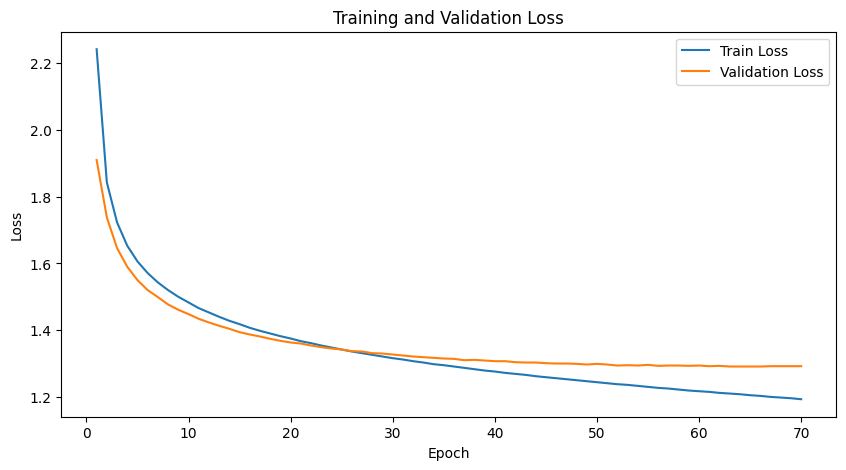

Loss plot saved to /content/drive/MyDrive/output_lstm_char/lstm_loss_plot_char.png.


In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig(LOSS_PLOT_PATH)
plt.show()
print(f'Loss plot saved to {LOSS_PLOT_PATH}.')

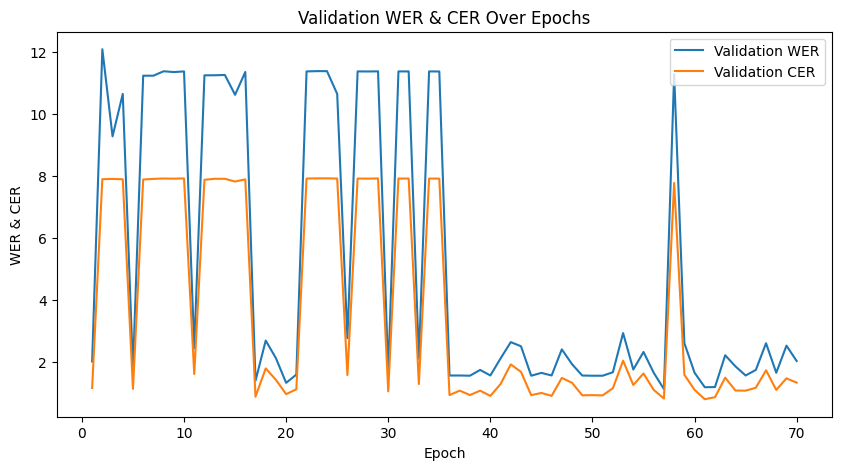

Plot saved to /content/drive/MyDrive/output_lstm_char/er_plot.png.


In [ ]:
# Plot validation CER & WER over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(valid_wers) + 1), valid_wers, label='Validation WER')
plt.plot(range(1, len(valid_cers) + 1), valid_cers, label='Validation CER')
plt.xlabel('Epoch')
plt.ylabel('WER & CER')
plt.legend()
plt.title('Validation WER & CER Over Epochs')
plt.savefig(ER_PLOT_PATH)

plt.show()
print(f'Plot saved to {ER_PLOT_PATH}.')

In [ ]:
def translate_sentence(sentence, model, char2idx, idx2char, device, max_len=MAX_LEN):
    model.eval()
    chars = list(sentence)
    tokens = [BOS_IDX] + [char2idx.get(c, UNK_IDX) for c in chars] + [EOS_IDX]
    tokens = tokens[:max_len]
    src_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model.predict(src_tensor, max_len)
    outputs = outputs.squeeze(0).tolist()
    # Stop at EOS token
    if EOS_IDX in outputs:
        eos_index = outputs.index(EOS_IDX)
        outputs = outputs[:eos_index]
    translation = ''.join([idx2char[idx] for idx in outputs if idx not in [PAD_IDX, BOS_IDX, EOS_IDX]])
    return translation

In [ ]:
def evaluate_and_save(model, df, src_sequences, trg_sequences, char2idx, idx2char, file_name):
    model.eval()
    predictions = []
    cer_scores = []
    wer_scores = []

    for src_ids, trg_ids in tqdm(zip(src_sequences, trg_sequences), total=len(src_sequences), desc=f'Evaluating {file_name}'):
        src_sentence = ''.join([idx2char[idx] for idx in src_ids if idx not in [BOS_IDX, EOS_IDX, PAD_IDX]])
        trg_sentence = ''.join([idx2char[idx] for idx in trg_ids if idx not in [BOS_IDX, EOS_IDX, PAD_IDX]])

        pred_sentence = translate_sentence(src_sentence, model, char2idx, idx2char, DEVICE)
        predictions.append(pred_sentence)
        cer_score = cer(trg_sentence, pred_sentence)
        wer_score = wer(trg_sentence, pred_sentence)
        cer_scores.append(cer_score)
        wer_scores.append(wer_score)

    results_df = pd.DataFrame({
        'Source': df['inFormalForm'],
        'Target': df['FormalForm'],
        'Prediction': predictions,
        'CER': cer_scores,
        'WER': wer_scores
    })

    results_df = results_df.sort_values(by=['CER', 'WER'], ascending=[True, True])

    results_path = os.path.join(OUTPUT_DIR, file_name)
    results_df.to_csv(results_path, index=False)
    avg_cer = np.mean(cer_scores)
    avg_wer = np.mean(wer_scores)
    print(f'Results saved to {results_path}')
    print(f'Average CER: {avg_cer:.4f}')
    print(f'Average WER: {avg_wer:.4f}')
    return results_df

In [ ]:
model.load_state_dict(torch.load(BEST_MODEL_PATH))
print('Best model loaded.')

print('Evaluating on training data...')
train_results = evaluate_and_save(model, train_df, train_src, train_trg, char2idx, idx2char, 'train_results_char.csv')

print('Evaluating on validation data...')
val_results = evaluate_and_save(model, val_df, val_src, val_trg, char2idx, idx2char, 'val_results_char.csv')

print('Evaluating on test data...')
test_results = evaluate_and_save(model, test_df, test_src, test_trg, char2idx, idx2char, 'test_results_char.csv')

Best model loaded.
Evaluating on training data...


Evaluating train_results_char.csv: 100%|██████████| 40008/40008 [14:42<00:00, 45.35it/s]


Results saved to /content/drive/MyDrive/output_lstm_char/train_results_char.csv
Average CER: 0.9844
Average WER: 1.2503
Evaluating on validation data...


Evaluating val_results_char.csv: 100%|██████████| 5001/5001 [01:49<00:00, 45.87it/s]


Results saved to /content/drive/MyDrive/output_lstm_char/val_results_char.csv
Average CER: 0.9883
Average WER: 1.2546
Evaluating on test data...


Evaluating test_results_char.csv: 100%|██████████| 5002/5002 [01:50<00:00, 45.29it/s]

Results saved to /content/drive/MyDrive/output_lstm_char/test_results_char.csv
Average CER: 0.9875
Average WER: 1.2603


In [ ]:
model.load_state_dict(torch.load(BEST_CER_MODEL_PATH))
print('Best CER model loaded.')

print('Evaluating on training data using best CER model...')
train_results = evaluate_and_save(model, train_df, train_src, train_trg, char2idx, idx2char, 'train_results_best_cer.csv')

print('Evaluating on validation data using best CER model...')
val_results = evaluate_and_save(model, val_df, val_src, val_trg, char2idx, idx2char, 'val_results_best_cer.csv')

print('Evaluating on test data using best CER model...')
test_results = evaluate_and_save(model, test_df, test_src, test_trg, char2idx, idx2char, 'test_results_best_cer.csv')

Best CER model loaded.
Evaluating on training data using best CER model...


Evaluating train_results_best_cer.csv: 100%|██████████| 40008/40008 [31:38<00:00, 21.08it/s]


Results saved to /content/drive/MyDrive/output_lstm_char/train_results_best_cer.csv
Average CER: 1.9607
Average WER: 1.3655
Evaluating on validation data using best CER model...


Evaluating val_results_best_cer.csv: 100%|██████████| 5001/5001 [03:56<00:00, 21.12it/s]


Results saved to /content/drive/MyDrive/output_lstm_char/val_results_best_cer.csv
Average CER: 1.9709
Average WER: 1.3702
Evaluating on test data using best CER model...


Evaluating test_results_best_cer.csv: 100%|██████████| 5002/5002 [03:54<00:00, 21.36it/s]

Results saved to /content/drive/MyDrive/output_lstm_char/test_results_best_cer.csv
Average CER: 1.9313
Average WER: 1.3894
